In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets,transforms
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import numpy as np
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


In [10]:
# 数据预处理
train_transforms = v2.Compose([
    v2.RandomResizedCrop(224),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=15),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = v2.Compose([
    v2.Resize(224),
    v2.CenterCrop(224),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
train_path = "./dataset/train"
val_path = "./dataset/valid"

# 数据加载器
train_dataset = ImageFolder(train_path, transform=train_transforms)
val_dataset = ImageFolder(val_path, transform=val_transforms)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# 模型定义
class ResBlock(nn.Module):
    expansion = 4 
    
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        
    def forward(self, x):
        identity = x
        
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity
        out = self.relu(out)
        return out


class ResNet50(nn.Module):
    def __init__(self, num_classes=20):
        super().__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(64, 3, stride=1)   
        self.layer2 = self._make_layer(128, 4, stride=2)  
        self.layer3 = self._make_layer(256, 6, stride=2)  
        self.layer4 = self._make_layer(512, 3, stride=2)  
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * ResBlock.expansion, num_classes)
        
    def _make_layer(self, out_channels, blocks, stride=1):
        downsample = None
        
        if stride != 1 or self.in_channels != out_channels * ResBlock.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * ResBlock.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * ResBlock.expansion),
            )
        
        layers = []
        layers.append(ResBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * ResBlock.expansion
        
        for _ in range(1, blocks):
            layers.append(ResBlock(self.in_channels, out_channels))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # Stage 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        # Stage 2-5
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # 分类头
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [20]:
model = ResNet50(num_classes=20).to(device)

In [14]:
from tqdm import tqdm

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # 创建进度条
    pbar = tqdm(dataloader, desc='训练中', ncols=100)
    
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # 实时更新进度条显示
        current_acc = 100. * correct / total
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{current_acc:.2f}%'})
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


# 验证函数
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # 创建进度条
    pbar = tqdm(dataloader, desc='验证中', ncols=100)
    
    with torch.no_grad():
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # 实时更新进度条显示
            current_acc = 100. * correct / total
            pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{current_acc:.2f}%'})
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

In [ ]:
# 训练模型
num_epochs = 20
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

# 训练循环
best_val_acc = 0.0
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # 记录历史
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # 更新学习率
    scheduler.step()
    
    # 打印进度
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    # 保存最佳模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_resnet50.pth')
        print(f"保存最佳模型 (Val Acc: {val_acc:.2f}%)")

print(f"\n训练完成，最佳验证准确率: {best_val_acc:.2f}%")

验证中: 100%|████████████████████████████████| 4/4 [00:01<00:00,  3.69it/s, loss=3.0394, acc=28.50%]


Epoch [1/20] Train Loss: 2.5876 | Train Acc: 18.63% | Val Loss: 2.2699 | Val Acc: 28.50%
保存最佳模型 (Val Acc: 28.50%)


验证中: 100%|████████████████████████████████| 4/4 [00:01<00:00,  3.77it/s, loss=2.6924, acc=42.50%]


Epoch [2/20] Train Loss: 2.1874 | Train Acc: 29.42% | Val Loss: 1.9809 | Val Acc: 42.50%
保存最佳模型 (Val Acc: 42.50%)


验证中: 100%|████████████████████████████████| 4/4 [00:01<00:00,  3.76it/s, loss=2.3673, acc=49.00%]


Epoch [3/20] Train Loss: 1.9717 | Train Acc: 36.57% | Val Loss: 1.7437 | Val Acc: 49.00%
保存最佳模型 (Val Acc: 49.00%)


验证中: 100%|████████████████████████████████| 4/4 [00:01<00:00,  3.56it/s, loss=2.2713, acc=56.50%]


Epoch [4/20] Train Loss: 1.8162 | Train Acc: 41.97% | Val Loss: 1.6442 | Val Acc: 56.50%
保存最佳模型 (Val Acc: 56.50%)


验证中: 100%|████████████████████████████████| 4/4 [00:01<00:00,  3.79it/s, loss=1.5868, acc=59.00%]


Epoch [5/20] Train Loss: 1.7119 | Train Acc: 45.55% | Val Loss: 1.3329 | Val Acc: 59.00%
保存最佳模型 (Val Acc: 59.00%)


验证中: 100%|████████████████████████████████| 4/4 [00:01<00:00,  3.80it/s, loss=2.1986, acc=58.50%]


Epoch [6/20] Train Loss: 1.6074 | Train Acc: 48.63% | Val Loss: 1.4954 | Val Acc: 58.50%


验证中: 100%|████████████████████████████████| 4/4 [00:01<00:00,  3.64it/s, loss=1.1512, acc=59.50%]


Epoch [7/20] Train Loss: 1.5434 | Train Acc: 50.65% | Val Loss: 1.2279 | Val Acc: 59.50%
保存最佳模型 (Val Acc: 59.50%)


验证中: 100%|████████████████████████████████| 4/4 [00:01<00:00,  3.87it/s, loss=1.2134, acc=61.00%]


Epoch [8/20] Train Loss: 1.4758 | Train Acc: 52.98% | Val Loss: 1.1043 | Val Acc: 61.00%
保存最佳模型 (Val Acc: 61.00%)


验证中: 100%|████████████████████████████████| 4/4 [00:01<00:00,  3.76it/s, loss=1.8109, acc=65.00%]


Epoch [9/20] Train Loss: 1.4139 | Train Acc: 54.74% | Val Loss: 1.2688 | Val Acc: 65.00%
保存最佳模型 (Val Acc: 65.00%)


验证中: 100%|████████████████████████████████| 4/4 [00:01<00:00,  3.84it/s, loss=0.8194, acc=70.50%]


Epoch [10/20] Train Loss: 1.3484 | Train Acc: 56.70% | Val Loss: 0.9204 | Val Acc: 70.50%
保存最佳模型 (Val Acc: 70.50%)


验证中: 100%|████████████████████████████████| 4/4 [00:01<00:00,  3.81it/s, loss=1.0762, acc=66.50%]


Epoch [11/20] Train Loss: 1.3116 | Train Acc: 58.01% | Val Loss: 1.0070 | Val Acc: 66.50%


验证中: 100%|████████████████████████████████| 4/4 [00:01<00:00,  3.85it/s, loss=2.2745, acc=58.50%]


Epoch [12/20] Train Loss: 1.2596 | Train Acc: 59.30% | Val Loss: 1.4192 | Val Acc: 58.50%


验证中: 100%|████████████████████████████████| 4/4 [00:01<00:00,  3.73it/s, loss=0.9371, acc=67.00%]


Epoch [13/20] Train Loss: 1.2248 | Train Acc: 60.59% | Val Loss: 0.9439 | Val Acc: 67.00%


验证中: 100%|████████████████████████████████| 4/4 [00:01<00:00,  3.64it/s, loss=0.8383, acc=70.50%]


Epoch [14/20] Train Loss: 1.2048 | Train Acc: 61.18% | Val Loss: 0.8999 | Val Acc: 70.50%


验证中: 100%|████████████████████████████████| 4/4 [00:01<00:00,  3.31it/s, loss=0.8145, acc=74.00%]


Epoch [15/20] Train Loss: 1.1554 | Train Acc: 62.44% | Val Loss: 0.8068 | Val Acc: 74.00%
保存最佳模型 (Val Acc: 74.00%)


验证中: 100%|████████████████████████████████| 4/4 [00:01<00:00,  3.73it/s, loss=0.7585, acc=77.50%]


Epoch [16/20] Train Loss: 0.9850 | Train Acc: 68.04% | Val Loss: 0.7125 | Val Acc: 77.50%
保存最佳模型 (Val Acc: 77.50%)


验证中: 100%|████████████████████████████████| 4/4 [00:01<00:00,  3.81it/s, loss=1.1672, acc=79.50%]


Epoch [17/20] Train Loss: 0.9366 | Train Acc: 69.73% | Val Loss: 0.8010 | Val Acc: 79.50%
保存最佳模型 (Val Acc: 79.50%)


验证中: 100%|████████████████████████████████| 4/4 [00:01<00:00,  3.88it/s, loss=0.8995, acc=78.00%]


Epoch [18/20] Train Loss: 0.9099 | Train Acc: 70.33% | Val Loss: 0.7347 | Val Acc: 78.00%


验证中: 100%|████████████████████████████████| 4/4 [00:01<00:00,  3.88it/s, loss=0.8700, acc=77.00%]


Epoch [19/20] Train Loss: 0.8900 | Train Acc: 71.13% | Val Loss: 0.7282 | Val Acc: 77.00%


验证中: 100%|████████████████████████████████| 4/4 [00:01<00:00,  3.86it/s, loss=1.2545, acc=80.50%]

Epoch [20/20] Train Loss: 0.8808 | Train Acc: 71.05% | Val Loss: 0.8049 | Val Acc: 80.50%
保存最佳模型 (Val Acc: 80.50%)

训练完成，最佳验证准确率: 80.50%


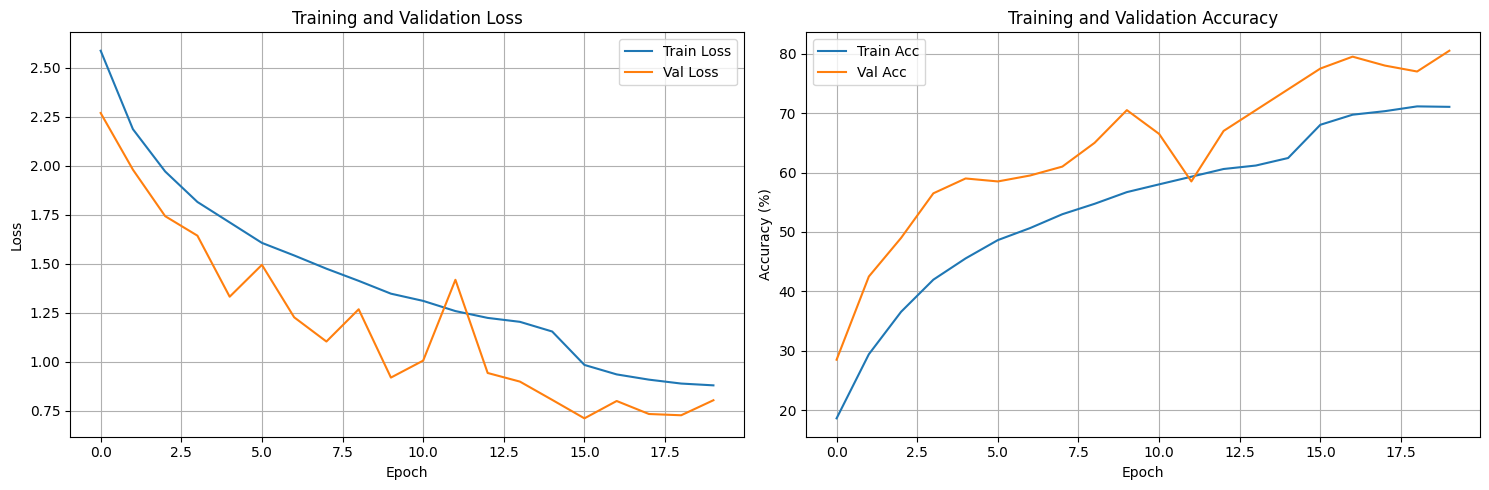

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# 损失曲线
ax1.plot(history['train_loss'], label='Train Loss')
ax1.plot(history['val_loss'], label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# 准确率曲线
ax2.plot(history['train_acc'], label='Train Acc')
ax2.plot(history['val_acc'], label='Val Acc')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()